<a href="https://colab.research.google.com/github/Chiebukar/Deep-Learning/blob/Chiebukar-patch-1/new_temperature_forcast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Temperature Forcasting with Jena climate dataset

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"chiebukar","key":"608f4279ecac88d5d34835c38326b695"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d kusuri/jena-climate

 61% 8.00M/13.2M [00:00<00:00, 77.9MB/s]
100% 13.2M/13.2M [00:00<00:00, 83.5MB/s]


In [4]:
!ls -d $PWD/*

/content/jena-climate.zip  /content/kaggle.json  /content/sample_data


In [5]:
!unzip \*.zip && rm *.zip

Archive:  jena-climate.zip
  inflating: jena_climate_2009_2016.csv  


In [6]:
!ls -d $PWD/*

/content/jena_climate_2009_2016.csv  /content/kaggle.json  /content/sample_data


In [7]:
file_dir = '/content/jena_climate_2009_2016.csv'

In [8]:
import numpy as np
import pandas as pd

In [9]:
jena_df = pd.read_csv(file_dir)
jena_df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [10]:
jena_df.shape

(420551, 15)

In [11]:
jena_df.columns

Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')

In [12]:
jena_arr = np.array(jena_df.iloc[:, 1:])
jena_arr[:2]

array([[ 9.96520e+02, -8.02000e+00,  2.65400e+02, -8.90000e+00,
         9.33000e+01,  3.33000e+00,  3.11000e+00,  2.20000e-01,
         1.94000e+00,  3.12000e+00,  1.30775e+03,  1.03000e+00,
         1.75000e+00,  1.52300e+02],
       [ 9.96570e+02, -8.41000e+00,  2.65010e+02, -9.28000e+00,
         9.34000e+01,  3.23000e+00,  3.02000e+00,  2.10000e-01,
         1.89000e+00,  3.03000e+00,  1.30980e+03,  7.20000e-01,
         1.50000e+00,  1.36100e+02]])

In [13]:
# standardize data
len_train = 200000
mean = jena_arr[:len_train].mean(axis=0)
std = jena_arr[:len_train].std(axis=0)
jena_arr = (jena_arr-mean)/std

In [14]:
# generator to yield batches of data from the recent past and future target  
def generator(data, min_index, max_index , lookback= 1440, delay=144, step= 6, batch_size=18, shuffle=False):

  """
  yield batches of data from the recent past and future target

  data = original input data
  min_index = minimum index of data to draw from
  max_index  maximum index of sata to draw from
  lookback= Number of timestamps back for input data per target
  delay = Number of timestamp in the future for target per lookback
  steps = period in timestamps to sample data
  batch_size = number of samples per batch
  shuffle = To shuffle the samples or not

  """

  if max_index == None:
    max_index = len(data) - delay - 1
  i = min_index + lookback

  while 1:
    if shuffle:
      rows = np.random.randint(min_index + lookback, max_index, size= batch_size)
    else:
      if i + batch_size >= max_index:
        i = min_index + lookback
      rows = np.arange(i, min(i + batch_size, max_index))
      i += len(rows)
    
    samples = np.zeros((len(rows), lookback  //step, data.shape[-1]))
    targets = np.zeros((len(rows),))

    for j, row in  enumerate(rows):
      indices = range(rows[j] - lookback, rows[j], step)
      samples[j] = data[indices]
      targets[j] = data[rows[j] + delay][1]
    yield samples, targets

In [15]:
train_gen = generator(data= jena_arr,
                      min_index= 0,
                      max_index= 200000,
                      shuffle= True)

valid_gen = generator(data= jena_arr,
                      min_index= 200001,
                      max_index = 300000,
                      shuffle = True)

test_gen = generator(data = jena_arr,
                     min_index = 300001,
                     max_index = None,
                     shuffle= True)


In [16]:
# get validation and test steps
lookback = 1440
val_steps = (300000 - 200001 - lookback)
test_steps = (len(jena_arr) - 300001 - lookback)

In [17]:
# establish baseline
def evaluate_naive_method():
  batch_maes = []
  for step in range(val_steps):
    samples, targets = next(valid_gen)
    preds = samples[:, -1, 1]
    mae = np.mean(np.abs(preds - targets))
    batch_maes.append(mae)
  return (np.mean(batch_maes))

In [18]:
# get baseline evaluation
mae = evaluate_naive_method()
celsius_mae = mae * std[1]
celsius_mae

2.5621376141307355

In [19]:

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout
from keras.callbacks import ModelCheckpoint

In [20]:
# build model
def build_model():
  model = Sequential()
  model.add(GRU(32, dropout= 0.1, recurrent_dropout= 0.25,
                 return_sequences=True,  input_shape = (None, jena_arr.shape[-1])))
  model.add(GRU(64, activation='tanh', dropout=0.5))
  model.add(Dense(8, activation= 'relu'))
  model.add(Dropout(0.1))
  model.add(Dense(1))

  model.compile(loss = 'mae', optimizer = 'rmsprop')
  return model

In [21]:
file_path= 'a_weights.best.hdf5'
checkpoint = ModelCheckpoint(file_path, monitor= 'val_loss', save_best_only= True, verbose= 1, mode= 'min')

In [ ]:
model = build_model()
history = model.fit(train_gen, steps_per_epoch = 500, epochs= 25, validation_data= valid_gen, 
                    validation_steps = 500, callbacks= checkpoint)

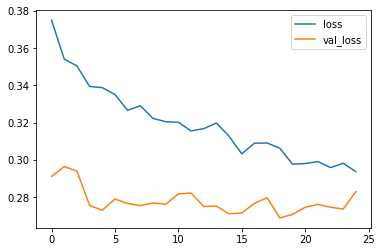

In [23]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

In [27]:
celsius_mae = 0.26 * std[1]
celsius_mae

2.3016497613732048